In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from pylab import rcParams
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller

from datetime import timedelta
import datetime
import math as m

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


#### Reino Unido - Índice PMI del sector servicios

El Indice de los Gerentes de Compra del Chartered Institute of Purchasing and Supply (CIPS), mide el nivel de actividad de los gerentes de compra en el sector servicios.
Cualquier lectura por encima de 50 indica expansión, mientras que una lectura por debajo de 50 indica contracción. < BR /> Da una indicación acerca de la salud de la industria de servicios en el Reino Unido. Los comerciantes ven de cerca estas encuestas ya que, como jefes de compras, por lo general tienen un acceso fácil a datos sobre el rendimiento de su empresa, lo que puede ser un indicador de los resultados económicos globales.
Un mayor lectura de la esperada debe ser tomada como positiva / alcista para el GBP, mientras que una lectura inferior a lo esperado debería ser tomada como negativa y bajista para el GBP.

In [2]:
pmi = pd.read_excel("Indice PMI sector servicios GBP.xlsx")

def Replace(str1):
    maketrans = str1.maketrans
    final = str1.translate(maketrans(',.', '.,', ' '))
    return final.replace(',', ", ")

actual = [float(Replace(pmi["Actual"][i])) for i in range(0, len(pmi["Actual"]))]
prevision = [float(Replace(pmi["Prevision"][i])) for i in range(0, len(pmi["Prevision"]))]
anterior = [float(Replace(pmi["Anterior"][i])) for i in range(0, len(pmi["Anterior"]))]
temp = [pmi["Fecha de publicacion"][i].replace(".","-") for i in range(0, len(pmi["Fecha de publicacion"]))]
temp = ["{2}-{1}-{0}".format(*temp[i].split('-')) for i in range(0,len(temp))]
fecha = [datetime.datetime.strptime(temp[i], "%Y-%m-%d") for i in range(0, len(temp))]

hours = []
for i in pmi["Hora"]:
    if isinstance(i,datetime.time):
        hours.append(i)
    else:
        hours.append(datetime.datetime.strptime(i.strip(), '%H:%M').time())
        
pmi["Actual"] = actual
pmi["Prevision"] = prevision
pmi["Anterior"] = anterior
pmi["Fecha de publicacion"] = fecha
pmi["Hora"] = hours
pmi.set_index("Fecha de publicacion", inplace=True);

pmi["Hora"] = [datetime.datetime.combine(pmi.index[i], pmi["Hora"][i]) for i in range(0, len(pmi.index))]
pmi.rename(columns = {"Hora": "Fecha y hora"}, inplace=True)
pmi.set_index("Fecha y hora", inplace=True)
pmi.drop(pmi.index[0], inplace=True)

In [3]:
pmi.head()

,Actual,Prevision,Anterior
Fecha y hora,,,
2021-04-07 10:30:00,56.3,56.8,49.5
2021-03-24 11:30:00,56.8,51.0,49.5
2021-03-03 11:30:00,49.5,49.7,39.5
2021-02-19 11:30:00,49.7,41.0,39.5
2021-02-03 11:30:00,39.5,38.8,38.8


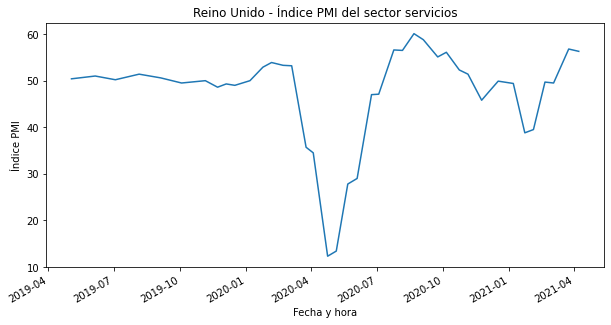

In [4]:
pmi["Actual"].plot(figsize=(10,5));
plt.ylabel("Índice PMI");
plt.title("Reino Unido - Índice PMI del sector servicios");

#### 1. Componente de Autocorrelación y Autocorrelación Parcial

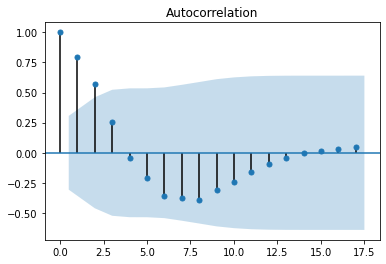

In [5]:
plot_acf(pmi["Actual"]);

Componente de autocorrelación igual a 2

//anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


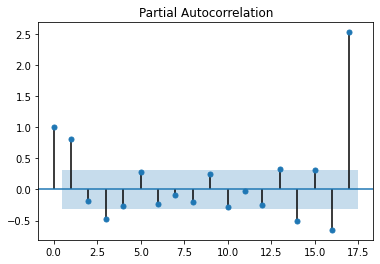

In [6]:
plot_pacf(pmi["Actual"]);

Componente de autocorrelación parcial igual a 1

#### 2. Prueba de Heterocedasticidad

In [7]:
def reglin(x,y):
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()
    B0 = model.params[0]
    B1 = model.params[1]
    x = x[:, 1]
    
    x2 = np.linspace(x.min(), x.max(),100)
    y_hat = x2 * B1 + B0
    plt.scatter(x, y, alpha=1)
    plt.plot(x2, y_hat, "r", alpha=1)
    plt.xlabel("Tiempo")
    plt.ylabel("PMI")
    return model, B0, B1

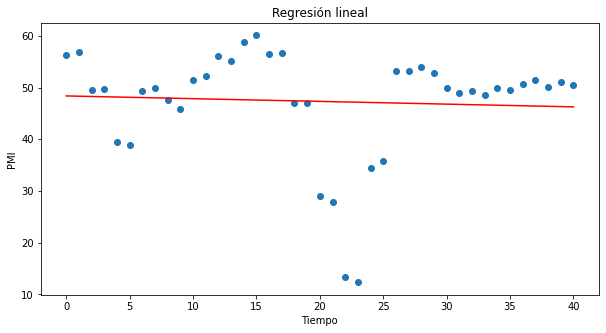

In [8]:
plt.figure(figsize=(10,5))
pmi.reset_index(inplace=True)
reglin(pmi.index, pmi["Actual"])
pmi.set_index("Fecha y hora", inplace=True)
plt.title("Regresión lineal");

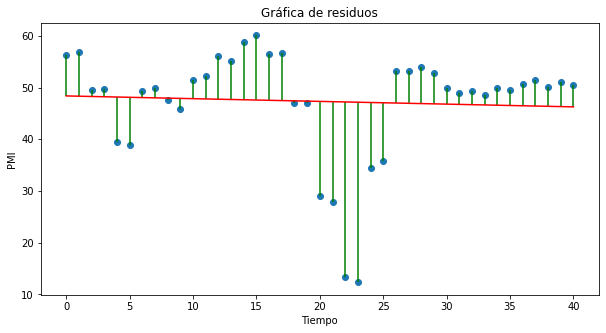

In [9]:
plt.figure(figsize=(10,5))
plt.title("Gráfica de residuos")
pmi.reset_index(inplace=True)
modelo, B0, B1 = reglin(pmi.index, pmi["Actual"])
residuales = modelo.resid
plt.errorbar(pmi.index, pmi["Actual"], xerr=0, yerr=[residuales, 0*residuales], linestyle = "None", color = "Green")
pmi.set_index("Fecha y hora", inplace=True)

In [10]:
breusch_pagan_p = smd.het_breuschpagan(modelo.resid, modelo.model.exog)[1]
print(breusch_pagan_p)
if breusch_pagan_p > 0.05:
    print("Existe homocedasticidad")
else:
    print("Existe heterocedasticidad")

0.8983027180981471
Existe homocedasticidad


#### 3. Prueba de Normalidad

In [11]:
stat, p = shapiro(pmi["Actual"])
alpha = 0.05
if p > alpha:
    print('Es normal')
else:
    print('No es normal')

No es normal


#### 4. Estacionalidad

In [12]:
rcParams['figure.figsize'] = 16, 6
decomposition = sm.tsa.seasonal_decompose(pmi["Actual"], model='additive', period=12)
fig = decomposition.plot()
plt.show()

TypeError: seasonal_decompose() got an unexpected keyword argument 'period'

#### 5. Estacionariedad

In [13]:
def estacionariedad(serie_de_tiempo):
    ## Test de DICKEY-FULLER
    adf_test = adfuller(serie_de_tiempo)
    if adf_test[1] > 0.05:
        print("No es estacionaria")
    else:
        print("Es estacionaria")

In [14]:
estacionariedad(pmi["Actual"])

No es estacionaria


#### 6. Detección de Atípicos

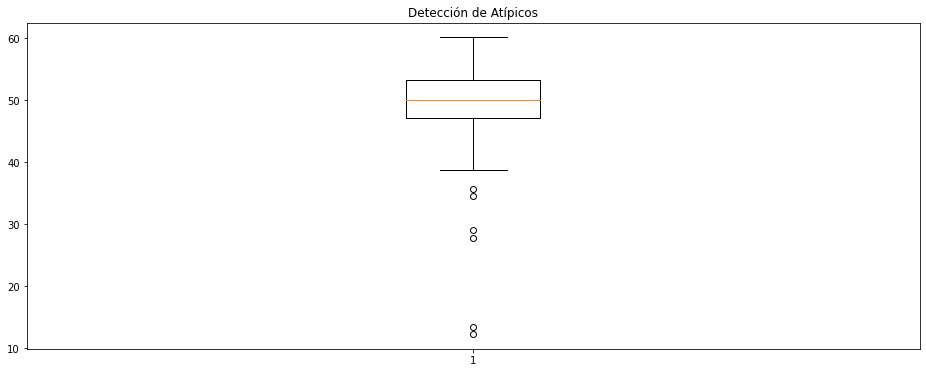

In [15]:
plt.boxplot(pmi["Actual"]);
plt.title("Detección de Atípicos");

#### Precios Históricos

In [16]:
gbp_usd_2019 = pd.read_csv("/Users/sofiamarianagarciamora/Documents/ITESO/OCTAVO/TRADING/myst_proyecto_e2/files/DAT_MT_GBPUSD_M1_2019.csv") 
gbp_usd_2020 = pd.read_csv("/Users/sofiamarianagarciamora/Documents/ITESO/OCTAVO/TRADING/myst_proyecto_e2/files/DAT_MT_GBPUSD_M1_2020.csv") 
gbp_usd_2021_e = pd.read_excel("/Users/sofiamarianagarciamora/Documents/ITESO/OCTAVO/TRADING/myst_proyecto_e2/files/DAT_XLSX_GBPUSD_M1_202101.xlsx") 
gbp_usd_2021_f = pd.read_excel("/Users/sofiamarianagarciamora/Documents/ITESO/OCTAVO/TRADING/myst_proyecto_e2/files/DAT_XLSX_GBPUSD_M1_202102.xlsx") 
gbp_usd_2021_m = pd.read_excel("/Users/sofiamarianagarciamora/Documents/ITESO/OCTAVO/TRADING/myst_proyecto_e2/files/DAT_XLSX_GBPUSD_M1_202103.xlsx") 
gbp_usd_2021_a = pd.read_excel("/Users/sofiamarianagarciamora/Documents/ITESO/OCTAVO/TRADING/myst_proyecto_e2/files/DAT_XLSX_GBPUSD_M1_202104.xlsx") 

In [ ]:
gbp_usd_2019 = pd.read_csv("DAT_MT_GBPUSD_M1_2019.csv")
gbp_usd_2020 = pd.read_csv("DAT_MT_GBPUSD_M1_2020.csv")
gbp_usd_2021_e = pd.read_excel("DAT_XLSX_GBPUSD_M1_202101.xlsx")
gbp_usd_2021_f = pd.read_excel("DAT_XLSX_GBPUSD_M1_202102.xlsx")
gbp_usd_2021_m = pd.read_excel("DAT_XLSX_GBPUSD_M1_202103.xlsx")
gbp_usd_2021_a = pd.read_excel("DAT_XLSX_GBPUSD_M1_202104.xlsx")

In [17]:


temp = [gbp_usd_2019["Fecha"][i].replace(".","-") for i in range(0, len(gbp_usd_2019["Fecha"]))]
fecha_2019 = [datetime.datetime.strptime(temp[i], "%Y-%m-%d") for i in range(0, len(temp))]

hours_2019 = []
for i in gbp_usd_2019["Hora"]:
    if isinstance(i,datetime.time):
        hours_2019.append(i)
    else:
        hours_2019.append(datetime.datetime.strptime(i.strip(), '%H:%M').time())
        
gbp_usd_2019["Fecha"] = fecha_2019
gbp_usd_2019["Hora"] = hours_2019

temp = [gbp_usd_2020["Fecha"][i].replace(".","-") for i in range(0, len(gbp_usd_2020["Fecha"]))]
fecha_2020 = [datetime.datetime.strptime(temp[i], "%Y-%m-%d") for i in range(0, len(temp))]

hours_2020 = []
for i in gbp_usd_2020["Hora"]:
    if isinstance(i,datetime.time):
        hours_2020.append(i)
    else:
        hours_2020.append(datetime.datetime.strptime(i.strip(), '%H:%M').time())
        
gbp_usd_2020["Fecha"] = fecha_2020
gbp_usd_2020["Hora"] = hours_2020

fechayhora_2019 = [datetime.datetime.combine(gbp_usd_2019["Fecha"][i], gbp_usd_2019["Hora"][i]) for i in range(0, len(gbp_usd_2019["Fecha"]))]
gbp_usd_2019["Fecha"] = fechayhora_2019
gbp_usd_2019.drop(["Hora"], axis=1, inplace=True)
gbp_usd_2019.rename(columns={"Fecha": "Fecha y hora"}, inplace=True)

fechayhora_2020 = [datetime.datetime.combine(gbp_usd_2020["Fecha"][i], gbp_usd_2020["Hora"][i]) for i in range(0, len(gbp_usd_2020["Fecha"]))]
gbp_usd_2020["Fecha"] = fechayhora_2020
gbp_usd_2020.drop(["Hora"], axis=1, inplace=True)
gbp_usd_2020.rename(columns={"Fecha": "Fecha y hora"}, inplace=True)

frames = [gbp_usd_2019, gbp_usd_2020, gbp_usd_2021_e, gbp_usd_2021_f, gbp_usd_2021_m, gbp_usd_2021_a]
precios_gbp_usd = pd.concat(frames)
precios_gbp_usd.set_index("Fecha y hora", inplace=True)

In [18]:
precios_gbp_usd.head()

,Open,High,Low,Close
Fecha y hora,,,,
2019-01-01 17:06:00,1.27459,1.27459,1.27250,1.27250
2019-01-01 17:11:00,1.27227,1.27227,1.27227,1.27227
2019-01-01 17:12:00,1.27294,1.27294,1.27294,1.27294
2019-01-01 17:13:00,1.27294,1.27295,1.27294,1.27295
2019-01-01 17:14:00,1.27295,1.27295,1.27277,1.27277


In [19]:
def f_escenario(data):
    """
    Paramemters
    -----------
    data: Datos historicos descargados 
    ---------
    returns
    -------
    data: Se le agrega columna de escenarios (ABCD) según su valor 
    """

    data['Escenario'] = None

    for i in range(len(data)):
        if data.iloc[i, 0] >= data.iloc[i, 1] and \
                data.iloc[i, 1] >= data.iloc[i, 2]:
            data.iloc[i, 3] = 'A'

        elif data.iloc[i, 0] >= data.iloc[i, 1] and \
                data.iloc[i, 1] < data.iloc[i,2]:
            data.iloc[i, 3] = 'B'

        elif data.iloc[i, 0] < data.iloc[i, 1] and \
                data.iloc[i, 1] >= data.iloc[i, 2]:
            data.iloc[i, 3] = 'C'

        elif data.iloc[i, 0] < data.iloc[i, 1] and \
                data.iloc[i, 1] < data.iloc[i, 2]:
            data.iloc[i, 3] = 'D'

    return data

In [20]:
f_escenario(pmi);

In [21]:
def f_metricas(indicador):    
    """
    Paramemters
    -----------
    data: 
    ---------
    returns
    -------
    data: 
    """
    date_time = []
    for i in indicador.index:
        date_time.append(datetime.datetime.fromtimestamp(datetime.datetime.timestamp(i)))

    tiempos = []
    for i in date_time:
        for j in range(1,62):
            tiempos.append(i - datetime.timedelta(minutes=31) + datetime.timedelta(minutes=j))

    df_filtrado_por_indicador = pd.concat([precios_gbp_usd[precios_gbp_usd.index == str(i)] for i in tiempos])

    direccion = []
    iterador_t_0 = list(range(-31, len(df_filtrado_por_indicador), 61))
    iterador_t_0.pop(0);
    iterador_t_30 = list(range(-1, len(df_filtrado_por_indicador), 61))
    iterador_t_30.pop(0);
    
    #(Dirección) Close (t_30) - Open(t_0)

    for i in iterador_t_0:  
        t_0 = df_filtrado_por_indicador.iloc[i, 0]
        for j in iterador_t_30:
            t_30 = df_filtrado_por_indicador.iloc[j, 3]
        direccion.append(t_30 - t_0)
    
    uno_y_menos_uno = []
    
    for i in direccion:
        if i > 0:
            uno_y_menos_uno.append(1)
        if i < 0:
            uno_y_menos_uno.append(-1)

    indicador["Direccion"] = uno_y_menos_uno
    
    #(Pips Alcistas) High(t_0 : t_30) – Open(t_0)
    
    high_hasta_t_30 = []
    for i in iterador_t_0: 
        high_hasta_t_30.append(max(df_filtrado_por_indicador.iloc[i: i + 31,1]))

    pips_alcistas = []
    for i in iterador_t_0:
        t_0 = df_filtrado_por_indicador.iloc[i, 0]
        for j in high_hasta_t_30:
            t_max = j
        pips_alcistas.append(t_max - t_0)
        
    indicador["Pips Alcistas"] = pips_alcistas
    indicador["Pips Alcistas"] = [m.floor(abs(i* 1000)) for i in  indicador["Pips Alcistas"]]
    
    #(Pips Bajistas) Open(t_0) – Low(t_0 : t_30) 
    
    low_hasta_t_30 = []
    for i in iterador_t_0: 
        low_hasta_t_30.append(min(df_filtrado_por_indicador.iloc[i: i + 31,1]))

    pips_bajistas = []
    for i in iterador_t_0:
        t_0 = df_filtrado_por_indicador.iloc[i, 0]
        for j in low_hasta_t_30:
            t_min = j
        pips_bajistas.append(t_0 - t_min)
        
    indicador["Pips Bajistas"] = pips_bajistas
    indicador["Pips Bajistas"] = [m.floor(abs(i* 1000)) for i in  indicador["Pips Bajistas"]]
    
    #(Volatilidad) High(t_-30 : t_30) ,  - mínimo low (t_-30:t_30)
    
    high_hasta_t_30_2 = []
    for i in iterador_t_0: 
        high_hasta_t_30_2.append(max(df_filtrado_por_indicador.iloc[i - 30: i + 31, 1]))
        
    low_hasta_t_30_2 = []
    for i in iterador_t_0: 
        low_hasta_t_30_2.append(min(df_filtrado_por_indicador.iloc[i - 30: i + 31, 2]))

    indicador["Volatilidad"] = [high_hasta_t_30_2[i] - low_hasta_t_30_2[i] for i in range(0, len(high_hasta_t_30))]
    indicador["Volatilidad"] = [m.floor(abs(i* 1000)) for i in  indicador["Volatilidad"]]
     
    return indicador

In [22]:
f_metricas(pmi)

,Actual,Prevision,Anterior,Escenario,Direccion,Pips Alcistas,Pips Bajistas,Volatilidad
Fecha y hora,,,,,,,,
2021-04-07 10:30:00,56.3,56.8,49.5,C,-1,65,69,6
2021-03-24 11:30:00,56.8,51.0,49.5,A,-1,60,65,1
2021-03-03 11:30:00,49.5,49.7,39.5,C,-1,86,91,2
2021-02-19 11:30:00,49.7,41.0,39.5,A,-1,89,94,1
2021-02-03 11:30:00,39.5,38.8,38.8,A,-1,52,57,1
2021-01-22 11:30:00,38.8,49.9,49.4,C,-1,54,58,2
2021-01-06 11:30:00,49.4,49.9,47.6,C,-1,45,50,5
2020-12-16 11:30:00,49.9,50.5,47.6,C,-1,36,41,2
2020-12-03 11:30:00,47.6,45.8,51.4,B,-1,36,41,2


In [23]:
def f_escenarios(data):
    """
    Paramemters
    -----------
    data: Datos historicos descargados 
    ---------
    returns
    -------
    data: Data Frame reducido con columnas especificas
    """
    df_escenarios = data[['Escenario', 'Direccion', 
                          'Pips Alcistas', 'Pips Bajistas', 'Volatilidad']] 
    return df_escenarios

In [24]:
escenario = f_escenarios(pmi)
escenario

,Escenario,Direccion,Pips Alcistas,Pips Bajistas,Volatilidad
Fecha y hora,,,,,
2021-04-07 10:30:00,C,-1,65,69,6
2021-03-24 11:30:00,A,-1,60,65,1
2021-03-03 11:30:00,C,-1,86,91,2
2021-02-19 11:30:00,A,-1,89,94,1
2021-02-03 11:30:00,A,-1,52,57,1
2021-01-22 11:30:00,C,-1,54,58,2
2021-01-06 11:30:00,C,-1,45,50,5
2020-12-16 11:30:00,C,-1,36,41,2
2020-12-03 11:30:00,B,-1,36,41,2


In [25]:
def f_decisiones(Operacion, SL, TP, Volumen):
    """
    Paramemters
    -----------
    data: Datos historicos descargados 
    ---------
    returns
    -------
    data: Dataframe de decision 
    """
    df_decisiones = pd.DataFrame(columns=['Escenario', 'Operacion', 'SL', 'TP', 'Volumen']) 
    df_decisiones['Escenario'] = ['A', 'B', 'C', 'D'] 
    df_decisiones['Operacion'] = Operacion 
    df_decisiones['SL'] = SL 
    df_decisiones['TP'] = TP 
    df_decisiones['Volumen'] = Volumen 
    return df_decisiones 

In [28]:
Operacion= ['Compra', 'Compra', 'Venta','Venta']
SL, TP = [10, 10, 10, 10] , [20, 20, 20, 20]
Volumen= [200, 200, 200, 200]
decision = f_decisiones(Operacion, SL, TP, Volumen)
decision

,Escenario,Operacion,SL,TP,Volumen
0,A,Compra,10,20,200
1,B,Compra,10,20,200
2,C,Venta,10,20,200
3,D,Venta,10,20,200


In [51]:
def f_backtest(escenarios, decisiones, capital_inicial):
    """
    Paramemters
    -----------
    data: 
    ---------
    returns
    -------
    data
    """
    backtest = pd.merge(escenarios, decisiones)
    backtest['Fecha y hora'] = escenarios.index
    backtest['Resultado'] = 0
    backtest['Pips'] = 0
    backtest['Capital'] = 0
    backtest['Capital_acumulado'] = 0

    for i in range(len(backtest)):
      #PIPS  
        if backtest.loc[i, 'Operacion'] == 'Venta':
            if backtest.loc[i, 'Pips Alcistas'] >= backtest.loc[i, 'SL']:
                backtest.loc[i, 'Pips'] = backtest.loc[i, 'SL'] * (-1)
            elif backtest.loc[i, 'Pips Bajistas'] >= backtest.loc[i, 'TP']:
                backtest.loc[i, 'Pips'] = backtest.loc[i, 'TP']
        if backtest.loc[i, 'Operacion'] == 'Compra':
            if backtest.loc[i, 'Pips Alcistas'] >= backtest.loc[i, 'TP']:
                backtest.loc[i, 'Pips'] = backtest.loc[i, 'TP']
            elif backtest.loc[i, 'Pips Bajistas'] >= backtest.loc[i, 'SL']:
                backtest.loc[i, 'Pips'] = backtest.loc[i, 'SL'] * (-1)
    #RESULTADO  
        if backtest.loc[i, 'Pips'] >= 0:
            backtest.loc[i, 'Resultado'] = "Ganada"
        else:
            backtest.loc[i, 'Resultado'] = "Perdida"
    #CAPITAL
        backtest.loc[i, 'Capital'] = backtest.loc[i, 'Volumen'] * backtest.loc[i, 'Pips'] / 100
    #CAPITAL ACUMULADO
    backtest.loc[0, 'Capital_acumulado'] = capital_inicial + backtest.loc[0, 'Capital']
    for i in range(1, len(backtest)):
        backtest.loc[i, 'Capital_acumulado'] = backtest.loc[i - 1, 'Capital_acumulado'] + backtest.loc[i, 'Capital']

    del backtest['Direccion']
    del backtest['Pips Alcistas']
    del backtest['Pips Bajistas']
    del backtest['Volatilidad']
    del backtest['SL']
    del backtest['TP']
    backtest.set_index("Fecha y hora", inplace=True)
    return backtest

In [52]:
capital_inicial = 100000
f_backtest(escenario,decision,capital_inicial)

,Escenario,Operacion,Volumen,Resultado,Pips,Capital,Capital_acumulado
Fecha y hora,,,,,,,
2021-04-07 10:30:00,C,Venta,200,Perdida,-10,-20.0,99980.0
2021-03-24 11:30:00,C,Venta,200,Perdida,-10,-20.0,99960.0
2021-03-03 11:30:00,C,Venta,200,Perdida,-10,-20.0,99940.0
2021-02-19 11:30:00,C,Venta,200,Perdida,-10,-20.0,99920.0
2021-02-03 11:30:00,C,Venta,200,Perdida,-10,-20.0,99900.0
2021-01-22 11:30:00,C,Venta,200,Perdida,-10,-20.0,99880.0
2021-01-06 11:30:00,C,Venta,200,Perdida,-10,-20.0,99860.0
2020-12-16 11:30:00,C,Venta,200,Ganada,0,0.0,99860.0
2020-12-03 11:30:00,C,Venta,200,Perdida,-10,-20.0,99840.0
